In [94]:
import os
import pandas as pd
from policies.mappo import MAPPO
from environment.optimization_environment import OptimizationEnv
from environment.utils import parse_config
from datetime import datetime
import numpy as np
import seaborn as sns
import os
import neptune
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy
from other_algorithms.pso import ParticleSwarmOptimizer
import time
from scipy.stats import multivariate_normal
from dotenv import load_dotenv
load_dotenv()

True

In [95]:
def initialize(config_path, mode="train", **kwargs):
    env = OptimizationEnv(config_path)
    agent_policy = MAPPO(config_path)
    if mode == "test" or mode == "benchmark":
        model_path = kwargs.get("model_path", None)
        if model_path is None:
            raise ValueError("Model path must be provided for testing")
        agent_policy.load(model_path)
    return env, agent_policy

def print_items(**kwargs):
    for key, value in kwargs.items():
        print(key, value)
        
def get_action(observation_info, agent_policy, env):
    observation, observation_std = observation_info
    actions = np.zeros((env.n_agents, env.n_dim))
    for dim in range(env.n_dim):
        observation[dim] = observation[dim].astype(np.float32)
        #print(observation[dim])
        observation_std[dim] = observation_std[dim].astype(np.float32)
        action = agent_policy.select_action(observation[dim], observation_std[dim])
        actions[:, dim] = action
    return actions

def cal_densities(points):
    densities = np.array([multivariate_normal(mean=mean, cov=cov, allow_singular=True).pdf(points)
                              for mean, cov in zip(env.gmm.gmm.means_, env.gmm.gmm.covariances_)])
    return densities

def cal_densities_variances(densities):
    variances = []
    for dim in range(densities.shape[0]):
        densities_variances = np.var(densities[dim], axis=0)
        print(densities_variances)
        variances.append(densities_variances)
    return variances

In [96]:
config_path = 'config/config.json'
model_path = "models/exploiting_model.pth"
mode = "test"
env, agent_policy = initialize(config_path, mode=mode, model_path=model_path)
config = parse_config(config_path)
agent_policy.set_action_std(config["test_action_std"])

def display_gmm_details(gmm):
    print("Means: ", gmm.means_)
    print("Covariances: ", gmm.covariances_)
    print("Weights: ", gmm.weights_)


Loaded policy from:  models/exploiting_model.pth


(676, 2)


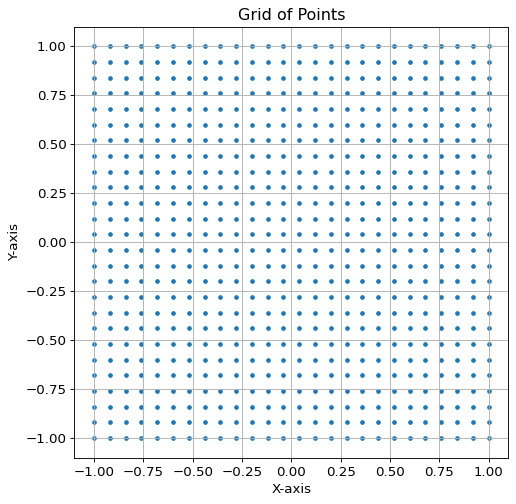

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Define the bounds of the grid
x_min, x_max = -1, 1
y_min, y_max = -1, 1

# Define the grid resolution (the spacing between points)
resolution = 0.08

# Create a meshgrid of x and y values within the bounds
x_values = np.arange(x_min, x_max + resolution, resolution)
y_values = np.arange(y_min, y_max + resolution, resolution)
xx, yy = np.meshgrid(x_values, y_values)

# Flatten the meshgrid to get the individual x and y coordinates
x_coordinates = xx.flatten()
y_coordinates = yy.flatten()

# Create a list of points as (x, y) tuples
points = list(zip(x_coordinates, y_coordinates))

# Convert the list of points to a NumPy array
points_array = np.array(points)
print(points_array.shape)   

# Plot the points
plt.scatter(points_array[:, 0], points_array[:, 1], s=10)  # Adjust marker size (s) as needed
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Grid of Points')
plt.grid(True)
plt.show()


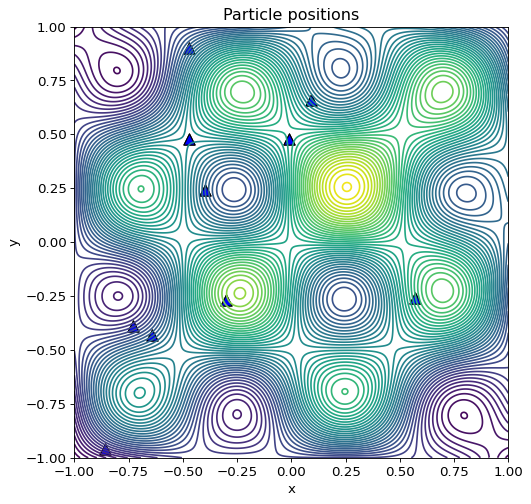

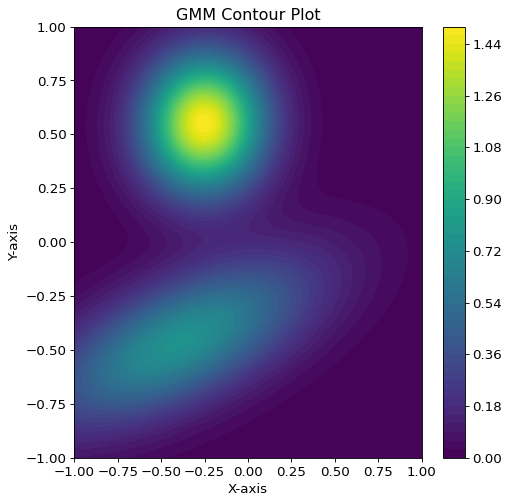

0.38550120083138373 -15.382262054167914 -3.1992658842953463 2.8720832195720267 8.248862020147218
0.18214905774041285
Uniformity Reward:  0.3526321344537981
Coverage Reward:  0.4994797086368366


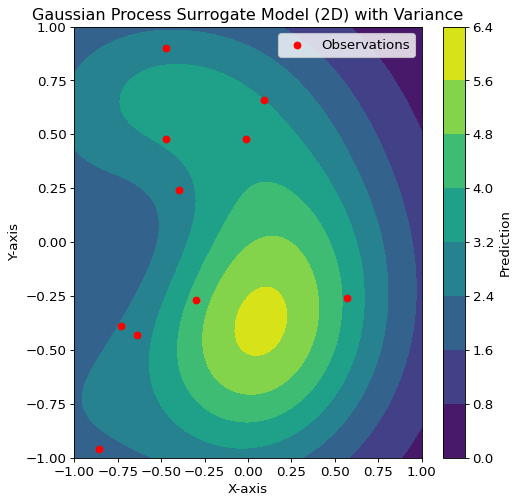

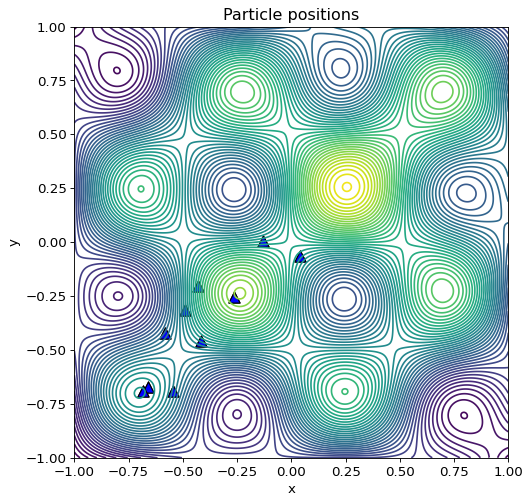

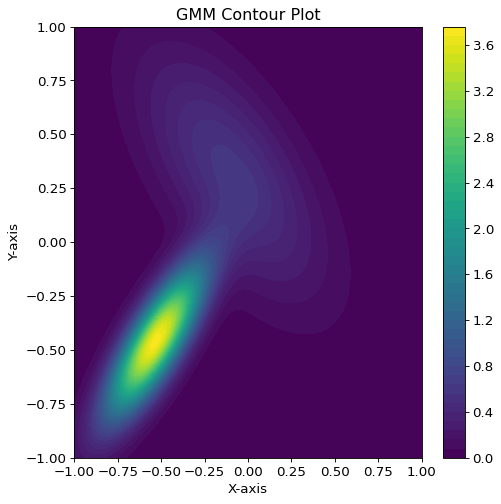

1.3161633125182832 -17.513909924248527 -3.8869400701518364 3.1810714984700397 10.119215878378425
0.1689356944326065
Uniformity Reward:  0.317823114674335
Coverage Reward:  0.4994797086368366


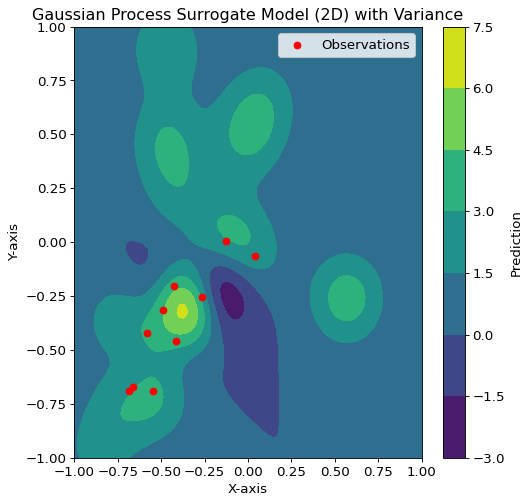

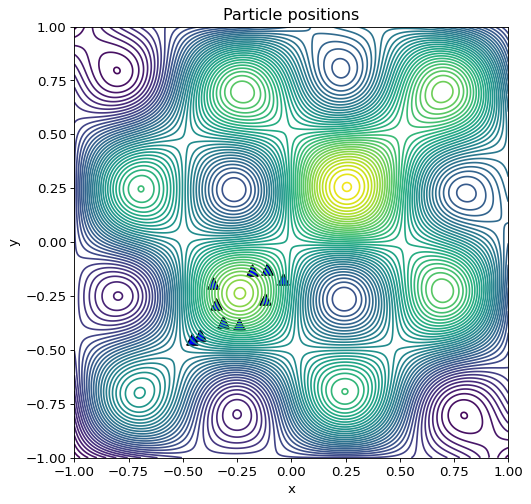

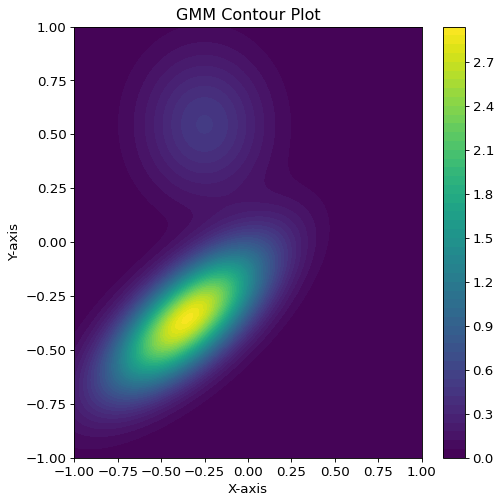

1.0643653151636474 -37.343288048793355 -6.051657666242625 6.9828923851605795 48.76078606273361
0.18180991999145552
Uniformity Reward:  0.14472346675791345
Coverage Reward:  0.4994797086368366


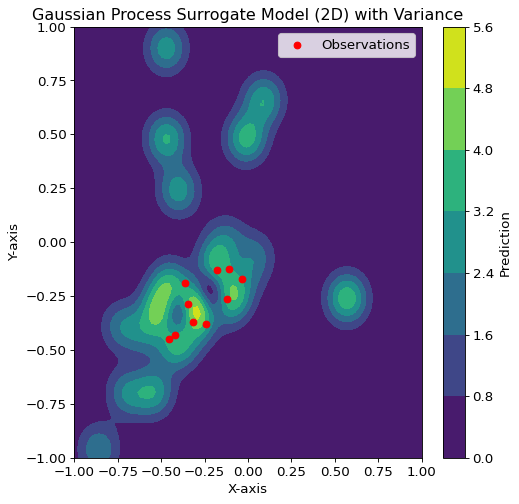

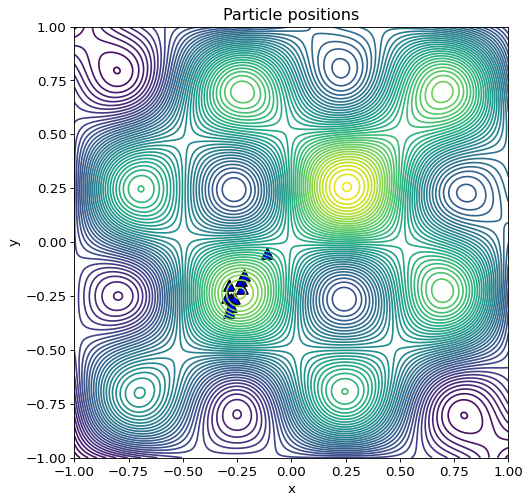

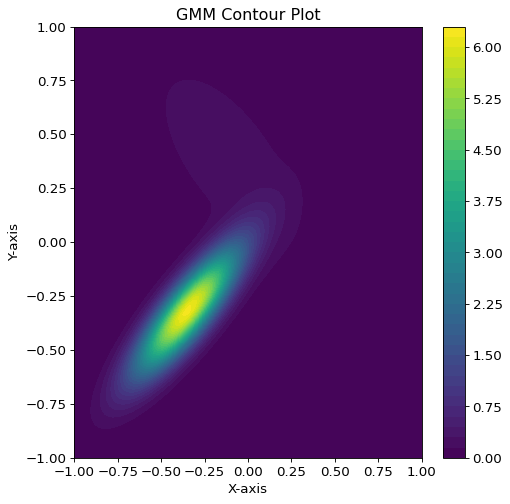

1.7839386281869105 -16.970753404973948 -4.751687276870878 3.451625637347377 11.913719540393688
0.18404064600178086
Uniformity Reward:  0.29246778863986284
Coverage Reward:  0.4994797086368366


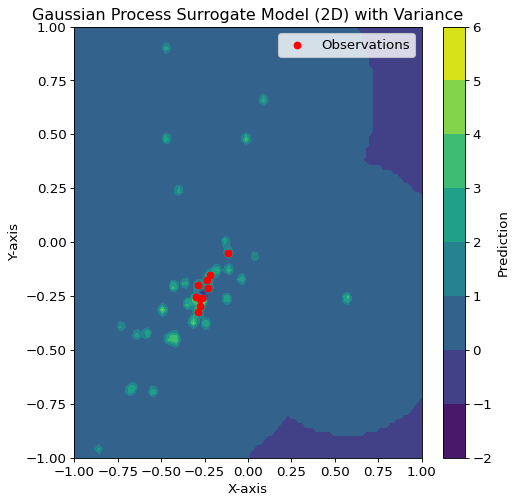

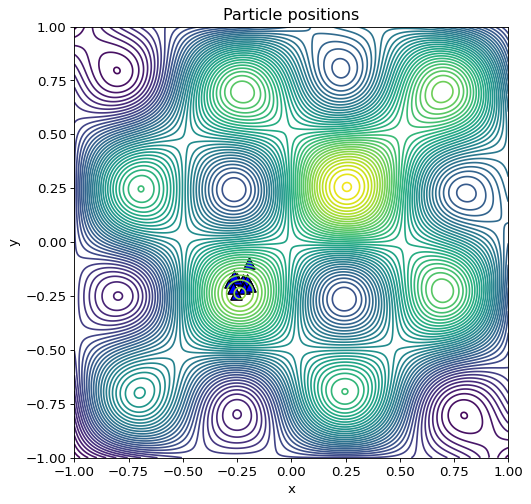

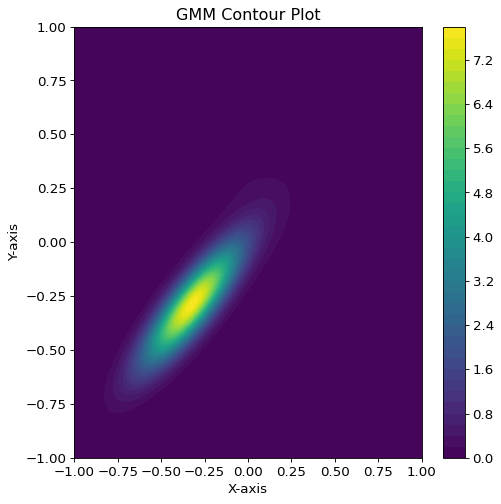

1.9855906623973998 -17.751981426355666 -5.142245366506982 3.6128784015503395 13.052890344388935
0.1830457355800637
Uniformity Reward:  0.27938559715767464
Coverage Reward:  0.4994797086368366


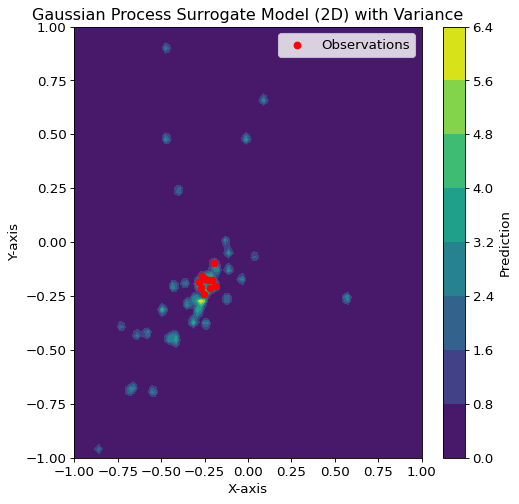

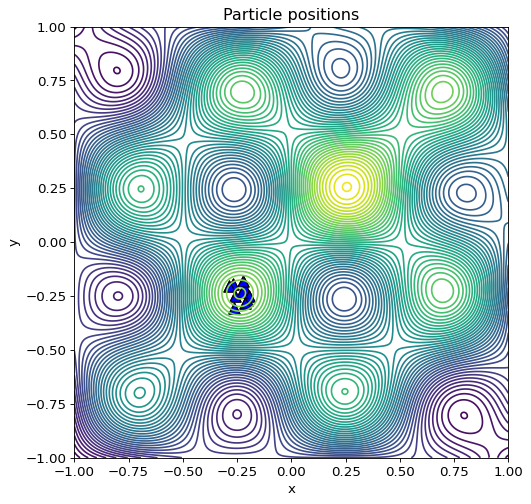

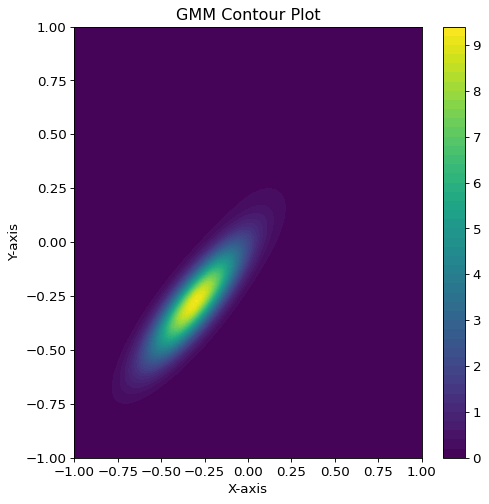

2.1817846901042275 -18.84936267141878 -5.443240056733096 3.7190446365500422 13.831293008651636
0.17683508049371213
Uniformity Reward:  0.2714188908194961
Coverage Reward:  0.4994797086368366


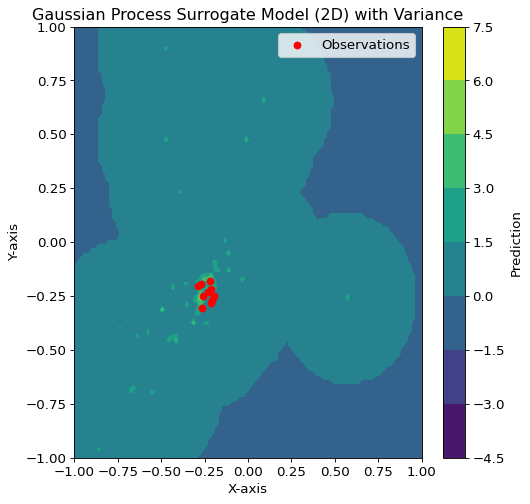

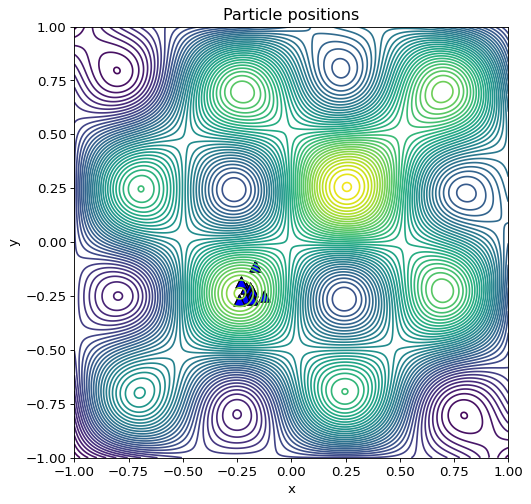

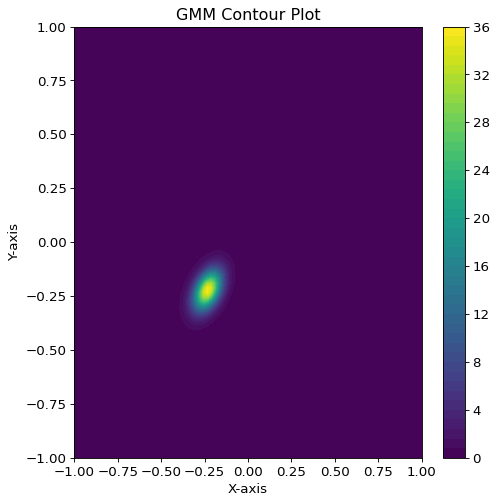

3.401389214176069 -18.45559463883169 -4.774756246272828 3.490103736597223 12.180824092209898
0.15967911035066926
Uniformity Reward:  0.28912770253298786
Coverage Reward:  0.4994797086368366


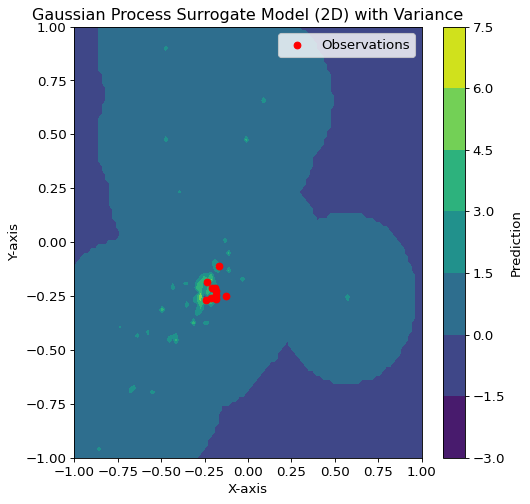

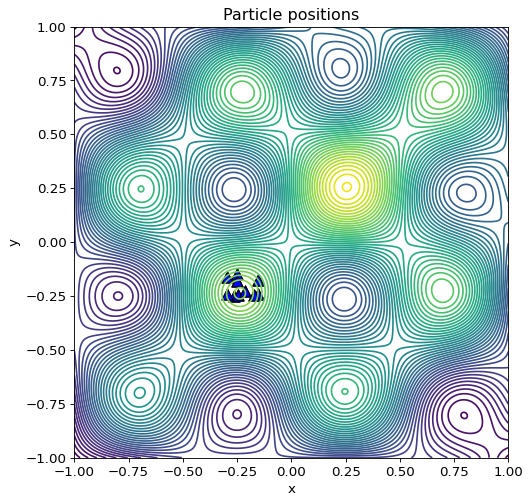

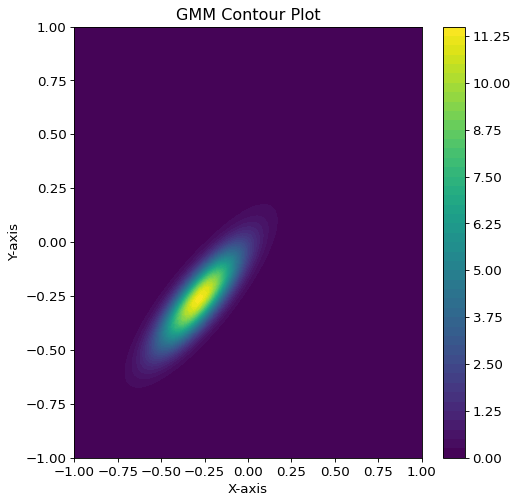

2.414888152055405 -19.930923950290463 -5.895379346610958 3.877745542766018 15.03691049444172
0.17353343548247824
Uniformity Reward:  0.2603914191937818
Coverage Reward:  0.4994797086368366


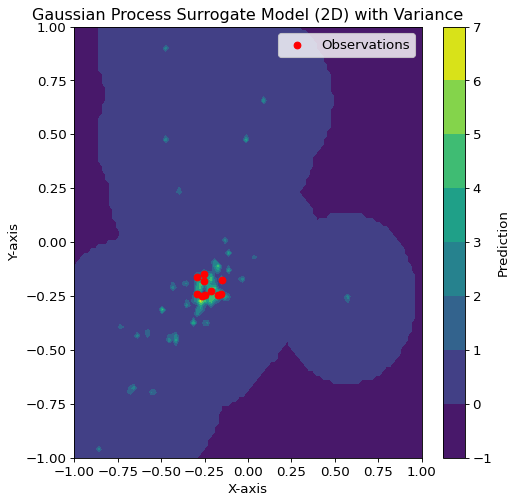

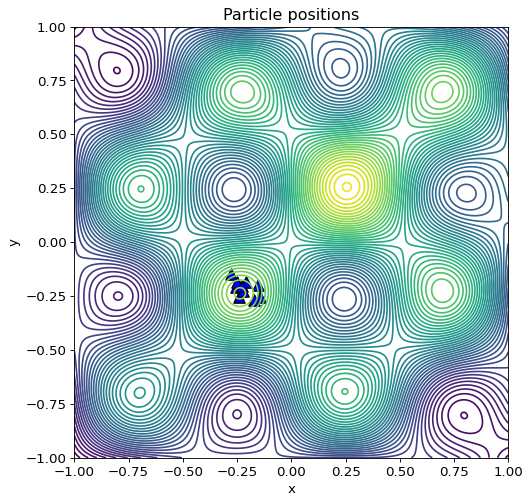

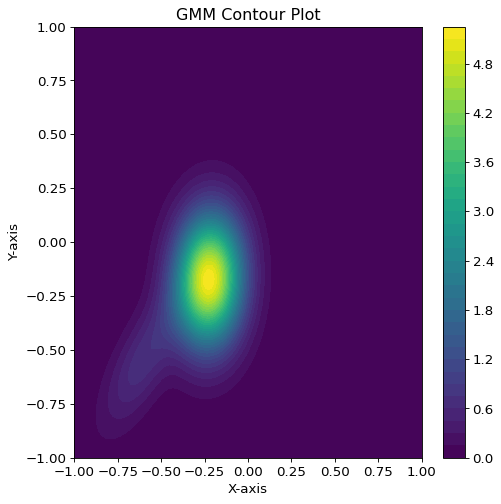

1.6290217412706054 -53.61140561260297 -13.741554165815426 12.868590970865437 165.60063357543945
0.23295603577482216
Uniformity Reward:  0.07847284318924463
Coverage Reward:  0.4994797086368366


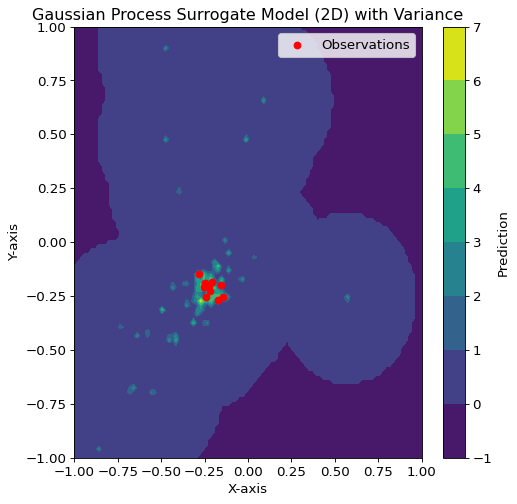

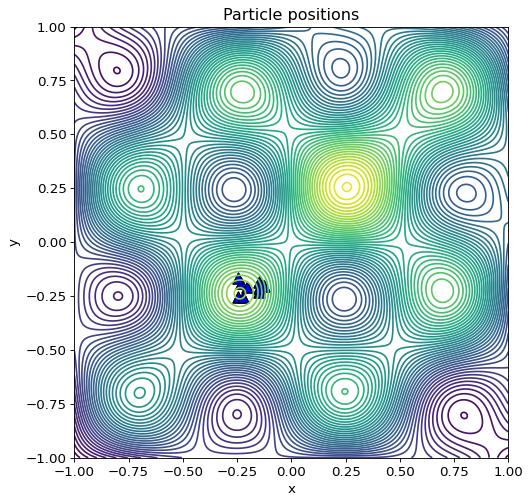

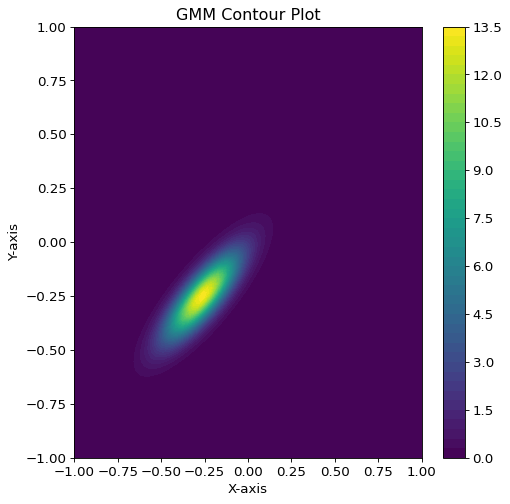

2.572018515067706 -21.022750422154722 -6.26368556630104 4.026853945263826 16.215552696486846
0.17066723374057619
Uniformity Reward:  0.25085721986278164
Coverage Reward:  0.4994797086368366


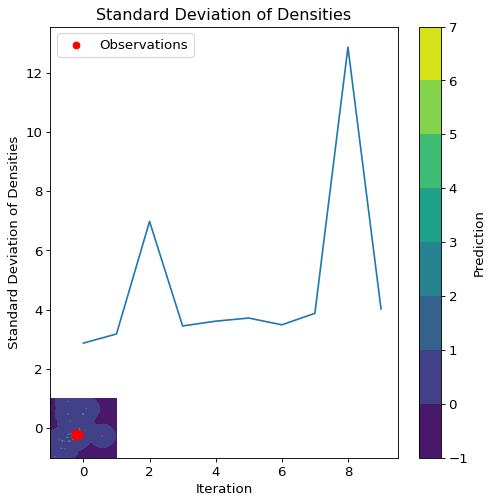

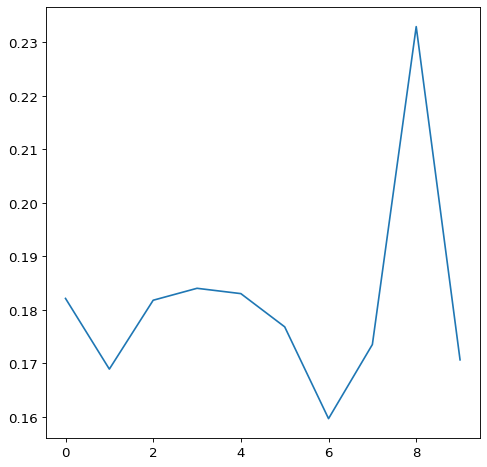

In [104]:
uniformity_reward = []
coverage_reward = []
densities_std = []
densities_std_norm = []
observation_info = env.reset()
for i in range(10):
    env.render()
    env.render("gmm")
    env.render("surrogate")
    uniformity_reward.append(env.gmm.calculate_reward(use_coverage=False, use_uniformity=True))
    coverage_reward.append(env.gmm.calculate_reward(use_coverage=True, use_uniformity=False))
    densities = env.gmm.gmm.score_samples(points_array)
    densities_norm = (densities - np.min(densities)) / (np.max(densities) - np.min(densities))
    densities_std_norm.append(np.std(densities_norm))
    densities_std.append(np.std(densities))
    print(np.max(densities, axis=0), np.min(densities, axis=0), np.mean(densities, axis=0), np.std(densities, axis=0), np.var(densities, axis=0))
    print(densities_std_norm[-1])
    print("Uniformity Reward: ", uniformity_reward[-1])
    print("Coverage Reward: ", coverage_reward[-1])
    actions = get_action(observation_info, agent_policy, env) #+ np.random.normal(-0.5, 0.5, actions.shape)
    # add noise to actions
    # actions += np.random.normal(-0.2, 0.2, actions.shape)
    # add noise to actions
    # actions += np.random.normal(0, 0.1, actions.shape)
    observation_info, reward, done, info = env.step(actions)
    
# plot the std of densities
plt.plot(densities_std)
plt.xlabel("Iteration")
plt.ylabel("Standard Deviation of Densities")
plt.title("Standard Deviation of Densities")
plt.show()

# plot the norm std densities
plt.plot(densities_std_norm)

    

In [102]:
densities_std

[2.6725470317467646,
 2.4055884860162666,
 2.0089210094891787,
 3.2027866160547545,
 8.472341122850093,
 10.155469894598399,
 1.9327389741457397,
 1.971596979231963,
 14.642970217785962,
 2.0098161785407527]

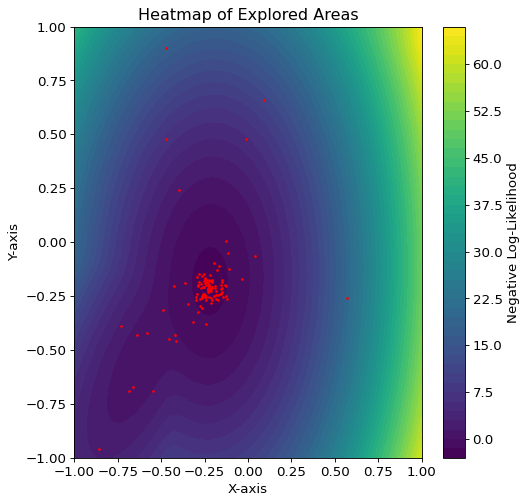

In [105]:
env.gmm.plot_heatmap()

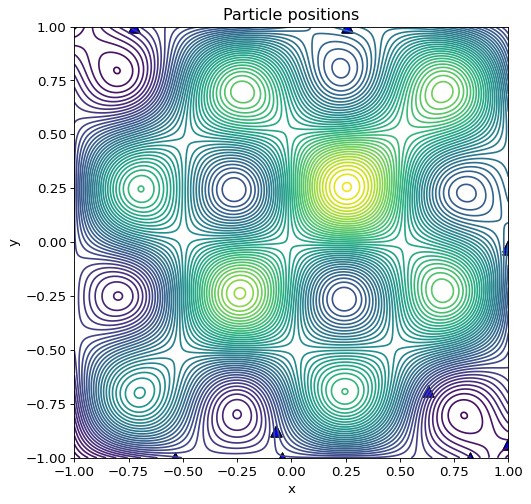

In [50]:
env.render()

In [51]:
densities = env.gmm.gmm.score_samples(env.gmm.fixed_points)
print(densities.shape)
print(np.max(densities, axis=0), np.min(densities, axis=0), np.mean(densities, axis=0), np.std(densities, axis=0))

(961,)
0.678882503901008 -15.482843006901945 -3.6569492933190126 3.419701502105064


In [52]:
print(uniformity_reward)
print(coverage_reward)

[0.15838293548455043, 0.15047383331422515, 0.17308574849865302, 0.18376026469308032, 0.20767477639415816, 0.23831132856167614, 0.26364985691815673, 0.2772911630307503, 0.2854301363856573, 0.29242318353939095]
[0.4994797086368366, 0.4994797086368366, 0.4994797086368366, 0.4994797086368366, 0.4994797086368366, 0.4994797086368366, 0.4994797086368366, 0.4994797086368366, 0.4994797086368366, 0.4994797086368366]


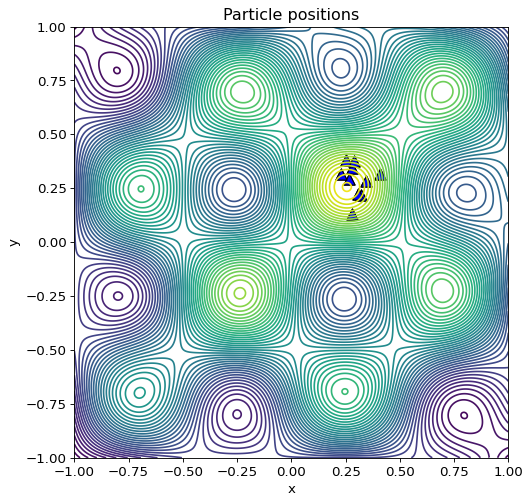

In [32]:
env.render()

In [ ]:
gmm = env.gmm.gmm
fig, ax = plt.subplots()
plot_gmm(gmm, ax)
plt.show()

In [ ]:
cal_densities(np.array([0.0, -0.25]))

In [ ]:
# wrap this in a function
cal_densities_variances(cal_densities(points))


In [ ]:
densities = cal_densities(points)
# get the max density, and the min density
max_density = np.max(densities, axis=0)

